<a name="cell-TOC"></a>

### 4. [Modeling ${\rm I\!R}$ with ${\rm I\!F}$](#cell-FPN-FR)

1. Error Accumulation

    1. [Symplectic Integration](#cell-FPN-SymplecticIntegration)
    2. [Machine-Epsilon $\epsilon_{machine}$](#cell-FPN-machine-epsilon)
    
    
2. Accuracy Limits

    1. [Root-Finding with Bisection](#cell-FPN-FR)
    2. [Density and Bounds of ${\rm I\!F}$](#cell-FPN-dense)
        1. [Overflow](#cell-FPN-numovr) and [Underflow](#cell-FPN-numndr)
        2. [Density of ${\rm I\!F}$ near `0.0` and Graceful Underflow](#cell-FPN-graceful)


3. Numerical Errors and Ways to Avoid them

    1. [Roundoff Error](#cell-FPN-roundoff): Week 4 Programming Assignment Problem 1
        1. [The `log` trick](#cell-FPN-dense-tricks)
        2. [Taylor Series Expansions](#cell-FPN-dense-taylor)
    2. [Catastrophic Cancellation](#cell-FPN-catacan): Week 4 Programming Assignment Problem 2
    3. [The Quadratic Formula](#cell-FPN-quadratic-formula)


4. Numerical Precision in Linear Algebra

    1. [Condition](#cell-sovling-condition)
        1. [Stability and Error Analysis](#cell-sovling-stability)
        2. [Pragmatic "Condition" Numbers: Stiffness](#cell-sovling-condition-stiffness)
    2. [Singular Value Decomposition (SVD)](#cell-sovling-Axb-math-svd)
        1. [Determinants](#cell-sovling-Axb-math-svd-vs-eigendecomposition)
        1. [Eigendecomposition](#cell-sovling-Axb-math-svd-vs-eigendecomposition)
        2. [Understanding $Ax$ with $Ax=UDV^Tx$](#cell-sovling-Axb-UDVt)

    3. [Matrix Condition Number](#cell-sovling-condition-matrix)





<a name="cell-FPN-FR"></a>

# 4. Modeling ${\rm I\!R}$ with ${\rm I\!F}$ ([Return to TOC](#cell-TOC))

---

${\rm I\!F}$ is not ${\rm I\!R}$ -- ${\rm I\!F}$ is just a model for ${\rm I\!R}$ -- and there are limits to how well ${\rm I\!F}$ can approximate ${\rm I\!R}$


- General ***floating-point*** ${\rm I\!F}$ representation $\quad$ `x`$=[x]_c \not = x\quad$ the exact ***real*** ${\rm I\!R}$ number

- ***Numerical precision*** is characterized by either
    - ***Resolution*** which is the last significant digit not subect to numerical imprecision
    - [***Machine-epsilon***](https://stackoverflow.com/questions/9528421/value-for-epsilon-in-python/9528651) $\epsilon_{machine}$ which provides the bound $[|x|]_c \leq |x|(1+\epsilon_{machine})$

We need to use ${\rm I\!F}$ carefully when we wish to carry out ${\rm I\!R}$-like operations on a computer 

> *Computer numbers are not the same as real numbers, and the arithmatic operations on computer numbers are not exactly the same as those of ordinary arithmetic*. 
>
> *The form of a mathematical expression and the way the expression should be evaluated in practice may be quite different.*
>
> -- James E. Gentle, Statistical Computing






# 4.1 Error Accumulation

<a name="cell-FPN-SymplecticIntegration"></a>

# 4.1.A Symplectic Integration ([Return to TOC](#cell-TOC))

---


Recall the *energy* function $H(\theta, v)$ made from the *potential energy* $U(\theta)$ and *kinetic energy* $K(v)$ 

$$H(\theta, v) = U(\theta) + K(v)$$

which is proportional to a log likelihood of an independent joint distribution  

$$H(\theta, v) \propto \log p(\theta, v) = \log[q(\theta)h(v)], \theta \perp\!\!\!\perp v$$

such as an independent normal distribution, in which case

$$ U(\theta) = \frac{1}{2}\theta^2 \quad \text{ and } \quad K(v) = \frac{1}{2}v^2$$

and ***conservation of energy*** means constant $\theta + v$ since according to the ***Hamiltonian dynamics*** differential equations

\begin{align*} \frac{d\theta}{dt} & = {} \frac{dH}{dv} & \frac{dv}{dt} & = {}  -\frac{dH}{d\theta} \\ & = {} \frac{dK}{dv} = v & & = {}   -\frac{dU}{d\theta}= -\theta  \end{align*}

which ensures that changes in $\theta$ and $v$ over time $t$ are equal and opposite


# 4.1.A Symplectic Integration

---

The solutions to these differential equations for the Gaussian based specifications of $U(\theta)$ and $K(v)$ have the form 


$$ \theta_t = \theta(t) = r \cos(a + t) \quad \text{ and } \quad v_t = v(t) = -r \sin(a + t) $$

which for $r=1$ and $a=0$ mean each $\theta(t)$ and $v(t)$ will lie on the unit circle.


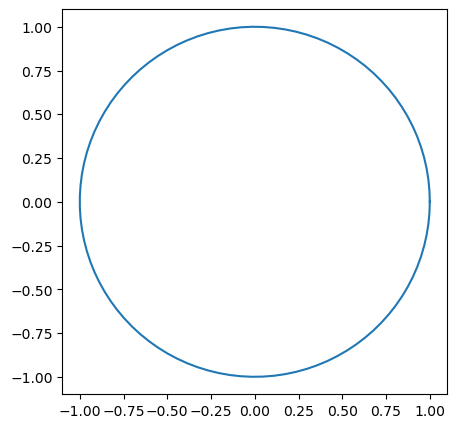

In [1]:
import matplotlib.pyplot as plt; import numpy as np
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5)); t = np.linspace(0,2*np.pi, 100)
ax.plot(np.cos(t), -np.sin(t)); ax.set_aspect('equal', adjustable='box') # https://www.delftstack.com/howto/matplotlib/how-to-make-a-square-plot-with-equal-axes-in-matplotlib/

# 4.1.A Symplectic Integration 

---

The following numerically approximate the solution trajectory of a differential equations.  These processes are referred to as ***integration*** because they add up all changes over time (like how ***integration*** add up areas under a curve)

1. ***Euler's method***: not a ***symplectic integrator***

| | | | | |
|-|-|-|-|-|
|| $ \begin{align*} 
\theta(t+\epsilon) & = {} \theta(t) + \epsilon \frac{d\theta(t)}{d t}\\
& = {} \theta(t) + \epsilon v(t)
\end{align*}$ | $\quad$ | $  \begin{align*} 
v(t+\epsilon) & = {} v(t) + \epsilon \frac{dv(t)}{d t}\\
& = {} v(t) - \epsilon \theta(t)
\end{align*}$ ||

2. ***Euler's method*** (***improved variant***): a ***first order symplectic integrator***

| | | | | |
|-|-|-|-|-|
|| $ \begin{align*} 
\theta(t+\epsilon) & = {} \theta(t) + \epsilon \frac{d\theta(t)}{d t}\\
& = {} \theta(t) + \epsilon v(t)
\end{align*}$ | $\quad$ | $  \begin{align*} 
v(t+\epsilon) & = {} v(t) + \epsilon \frac{dv(t+\epsilon)}{d t}\\
& = {} v(t) - \epsilon \theta(t+\epsilon)
\end{align*}$ ||

3. The ***leapfrog method*** (or ***leapfrog integration***): a  ***second order symplectic integrator***

| | | | | | |
|-|-|-|-|-|-|
|| $  \begin{align*} 
\theta(t+\epsilon/2) & = {} \theta(t) + \frac{\epsilon}{2} \frac{d\theta(t)}{d t}\\
& = {} \theta(t) + \frac{\epsilon}{2} v(t)
\end{align*}$ | $\quad$ | $  \begin{align*} 
v(t+\epsilon) & = {} v(t) + \epsilon \frac{dv(t+\epsilon/2)}{d t}\\
& = {} v(t) - \epsilon \theta(t+\epsilon/2)
\end{align*}$ | $\quad$ | $  \begin{align*} 
\theta(t+\epsilon) & = {} \theta(t + \epsilon/2) + \frac{\epsilon}{2} \frac{d\theta(t + \epsilon)}{d t}\\
& = {} \theta(t + \epsilon/2) + \frac{\epsilon}{2} v(t+\epsilon)
\end{align*}$|


# 4.1.A Symplectic Integration

--- 

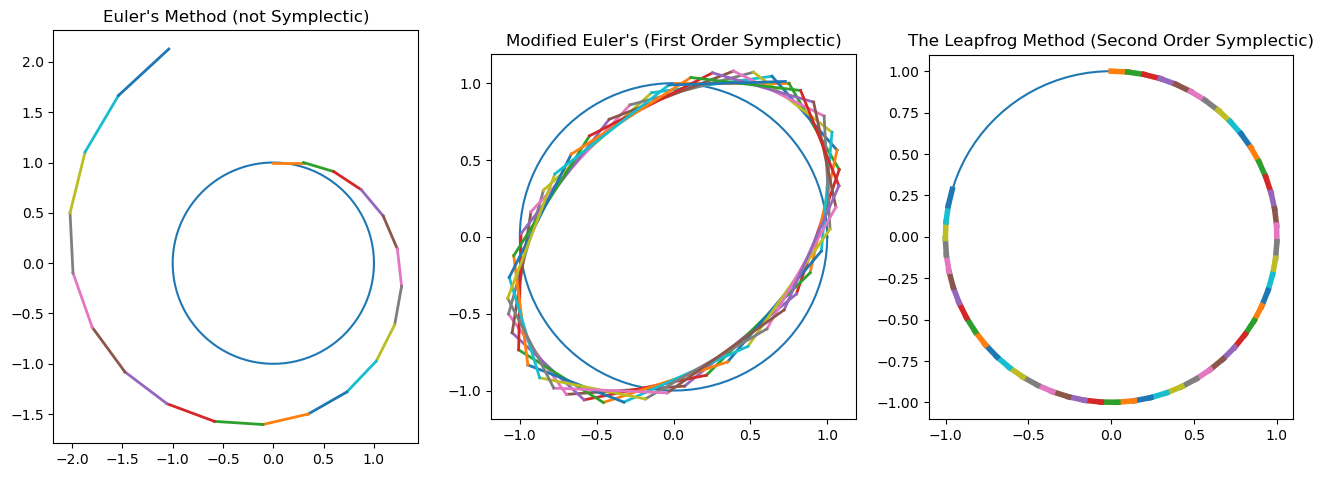

In [2]:
import matplotlib.pyplot as plt; import numpy as np; t = np.linspace(0,2*np.pi, 100); fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,8)) 
for i in range(3):
  ax[i].plot(np.cos(t), -np.sin(t)); ax[i].set_aspect('equal', adjustable='box')
theta_t, v_t, t, epsilon = 0, 1, 0, .3; ax[0].set_title("Euler's Method (not Symplectic)")
for i in range(20):
  v_t_e = v_t - epsilon * theta_t; theta_t_e = theta_t + epsilon * v_t; ax[0].plot([theta_t, theta_t_e], [v_t, v_t_e], linewidth=2) 
  theta_t, v_t, t = theta_t_e, v_t_e, t+epsilon  
theta_t, v_t, t, epsilon = 0, 1, 0, .75; ax[1].set_title("Modified Euler's (First Order Symplectic)")
for i in range(50):
  v_t_e = v_t - epsilon * theta_t; theta_t_e = theta_t + epsilon * v_t_e; ax[1].plot([theta_t, theta_t_e], [v_t, v_t_e], linewidth=2) 
  theta_t, v_t, t = theta_t_e, v_t_e, t+epsilon
theta_t, v_t, t, epsilon = 0, 1, 0, .1; ax[2].set_title("The Leapfrog Method (Second Order Symplectic)")
for i in range(50):
  v_t_e = v_t - epsilon / 2 * theta_t; theta_t_e = theta_t + epsilon * v_t_e; v_t_e = v_t_e - epsilon / 2 * theta_t_e; ax[2].plot([theta_t, theta_t_e], [v_t, v_t_e], linewidth=4) 
  theta_t, v_t, t = theta_t_e, v_t_e, t+epsilon

<a name="cell-FPN-machine-epsilon"></a>

# 4.1.B Machine-Epsilon $\epsilon_{machine}$ ([Return to TOC](#cell-TOC))
---

The ***machine-epsilon*** $\epsilon_{machine}$ bound means $\quad [x]_c = x(1 + \epsilon), |\epsilon| \leq \epsilon_{machine} \quad$ and in `python` $\epsilon_{machine}$ is 

```python
> np.finfo(float).eps
2.220446049250313e-16 # 2**-52 smallest value representable in the _significand_
# STA410_W24_Week1_Extra_PseudorandomnesAndComputerRepresentation.ipynb
```

so the ***resolution*** is `1e-15` (since `1e-16` can't be represented and is rounded to `2.220446049250313e-16`)


$$\scriptsize
\begin{align*}
[x_1+x_2]_c = {} & (x_1+x_2)(1+\epsilon_1)\\
[(x_1+x_2)(1+\epsilon_2) + x_3]_c = {} & ((x_1+x_2)(1+\epsilon_1)+x_3)(1+\epsilon_2)\\
\vdots \; {} & \\
\left[\sum_{i=1}^n x_i\right]_c = {} & \left[(x_1+x_2)\prod_{i=1}^{n-1} (1+\epsilon_i)\right] + \left[x_3 \prod_{i=2}^{n-1} (1+\epsilon_i)\right] + \cdots + \left[x_n(1+\epsilon_{n-1})\right]\\
\text{drop higher order terms} \quad \Longrightarrow \quad \approx {} & (x_1+x_2)\left(1+\sum_{i=1}^{n-1} \epsilon_i\right) + x_3 \left(1 + \sum_{i=2}^{n-1} \epsilon_i\right) + \cdots + x_n(1+\epsilon_{n-1})\\
= {} & \underset{\text{true value}}{\sum_{i=1}^{n} x_i} + \underbrace{\sum_{j=1}^{n-1} \left(\epsilon_j\sum_{i=1}^{j+1}x_i\right)}_{\text{numerical error}}
\end{align*}
$$



# 4.1.B Machine-Epsilon $\epsilon_{machine}$ 

---

The best order of operations is suggest by

$$\left[\sum_{i=1}^n x_i\right]_c = \underset{\text{true value}}{\sum_{i=1}^{n} x_i} + \underbrace{\sum_{j=1}^{n-1} \left(\epsilon_j\sum_{i=1}^{j+1}x_i\right)}_{\text{numerical error}}$$

which shows that the numerical error at step $j$ in the sum depends on the multiplication $\epsilon_j\sum_{i=1}^{j+1}x_i$
- adding smaller terms together first means the numerical error from each $\epsilon_j$ is smaller since $\sum_{i=1}^{j+1}x_i$ is smaller

Just like with ***Symplectic Intgration***, the limits of how well ${\rm I\!F}$ can approximate ${\rm I\!R}$ are compounded by the fact that numerical errors accumulate

- error from each step in a sequential process needs to be minimized
- numerical errors accumulate more slowly and there is less error overall if we sum smaller numbers first





# 4.2 Accuracy Limits

# 4.2.A Root-Finding with Bisection ([Return to TOC](#cell-TOC))

---

Accuracy of ALL numerical methods will be contrained by the limitations of the floating-point number system ${\rm I\!F}$


For example, the ***bisection method*** finds the roots of *continuous* functions using the following algorithm 

```python
# initialize `a` and `b` such that f(a) and f(b) 
# have different signs so we know they bound 0! 
for i in range(steps):
    if np.sign(f(a)) == np.sign(f(a + (b-a)/2)): 
        a = a + (b-a)/2 
    else:
        b = b - (b-a)/2
```

For 
$\quad f(x) = \frac{1 + 1/x - \log(x)}{(1+x)^2} \quad $ there does indeed exist an $x^* \in {\rm I\!R}$ such that $f(x^*) = 0$

but the numerically closest value to the root in ${\rm I\!F}$ is 

$$f(x= \texttt{3.591121476668622}) = \texttt{1.0534226635121335e-17} \not = 0$$



In [9]:
import numpy as np
import matplotlib.pyplot as plt
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
plt.style.use('ggplot')

# Look at the code below first before looking at
# the details of this function if you are intersted 
def bisection_root_finder(f, a, b, steps, ax=None):
  """
    Find a root of a function with the bisection method
    f: target function
    a: initial left bound
    b: initial right bound

    f(a) and f(b) must have different signs so we know they bound 0!
  """

  if ax:
    f_min = np.min([f(a),f(b)])
    f_max = np.max([f(a),f(b)])
    xs = np.linspace(a, b, 100) 
    ax.plot([a,b], 2*[0], 'k--')
    ax.plot(xs, f(xs))

  for i in range(steps):

    if ax:
      ax.plot([a,b], 2*[f_max - (i-1)*(f_max-f_min)/(steps-1)], 'k')
      ax.text(a, f_max - (i-1)*(f_max-f_min)/(steps-1), '|', ha='right', va='center')
      ax.text(b, f_max - (i-1)*(f_max-f_min)/(steps-1), '|', ha='left', va='center')
      # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html

    if np.sign(f(a)) == np.sign(f(b)):
      print("Something Unexpected Happened")
    else:
      #if f(a) * f(a + (b_a)/2) <= 0: # <- could underflow
      if np.sign(f(a)) == np.sign(f(a + (b-a)/2)): 
        a = a + (b-a)/2 
      else:
        b = b - (b-a)/2
        # We do not update the midpoint as (a+b)/2
        # because (as we shall see next) the above
        # operations have more numerical precision

  return a+(b-a)/2, f(a+(b-a)/2)

# 4.2.A Root-Finding with Bisection

---


(x,                 f(x)                  )
(3.591121476668624, -3.160267990536398e-17)
(3.591121476668622, 1.0534226635121335e-17) after 100 steps
(3.591121476668622, 1.0534226635121335e-17) after 150 steps


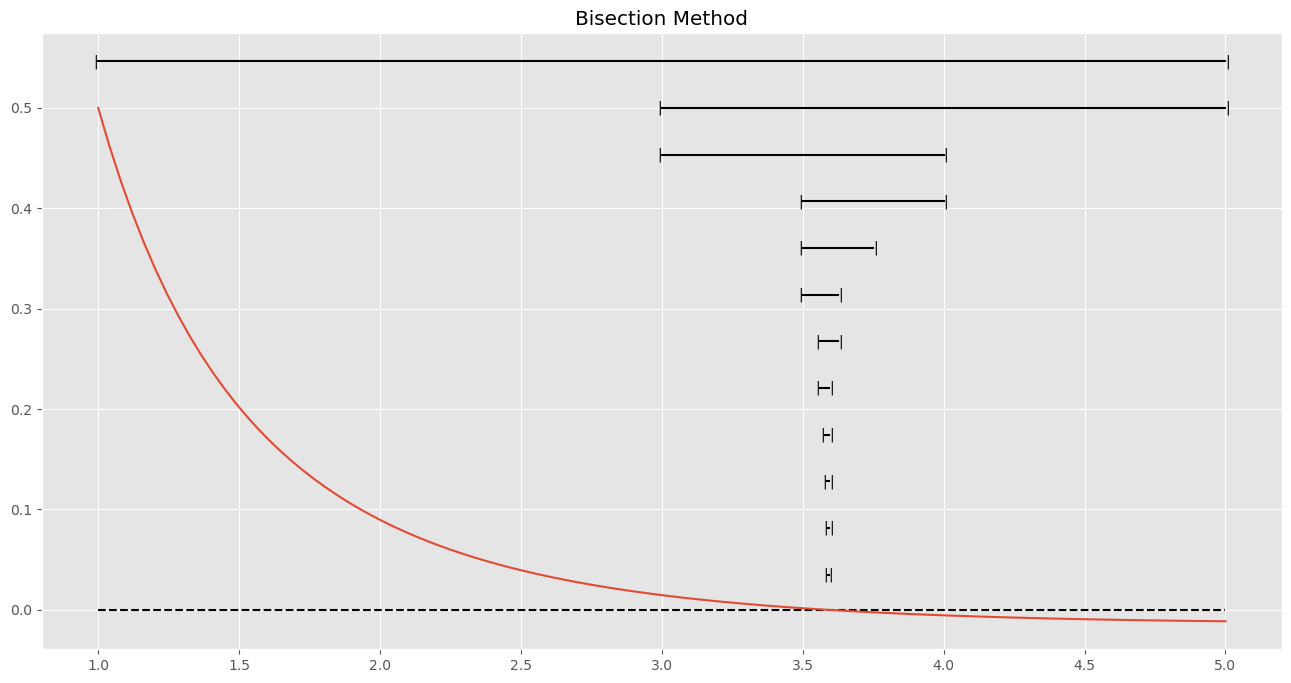

In [14]:
f = lambda x: (1 + 1/x - np.log(x))/(1+x)**2 # f = lambda x: x**3 - 4*x**2 + 18*x -115
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8)); bisection_root_finder(f, a=1, b=5, steps=12, ax=ax); _ = ax.set_title('Bisection Method'); print('(x,                 f(x)                  )'); print(bisection_root_finder(f, a=1, b=5, steps=50)); 
print(bisection_root_finder(f, a=1, b=5, steps=100), "after 100 steps"); print(bisection_root_finder(f, a=1, b=5, steps=150), "after 150 steps")

*This example is inspired by Chapter 2.1 **Univariate Problems** of Givens and Hoetings (pages 22-26), Chapter 3.3 [**Interval Bisection Method**](https://www.tf.uni-kiel.de/matwis/amat/comp_math/kap_1/backbone/r_se19.html) in J. Carstensen and J. M. Wagner's [**Computer Matematics**](https://www.tf.uni-kiel.de/matwis/amat/comp_math/), and the **Bisection Method** Section in Chapter 6.1 **Finding Roots of Equations** of Gentle (pages 246-248). [Errata Warning: on page 25 Givens and Hoeting report that bisection works for continuous $g'$, which is true; but, more generally bisection works for finding zeros of continuous functions $g$; and in Algorithm 6.2 **Bisection to Find a Root of an Equation** on page 247, Gentle does not point out that there is more numerical precision in the updates $a+(b-a)/2$ or $b-(b-a)/2$ rather than $(a+b)/2$ as pointed out by Givens and Hoetings on page on page 25.]*

<a name="cell-FPN-dense"></a>

# 4.2.B Density and Bounds of ${\rm I\!F}$ ([Return to TOC](#cell-TOC))
---

${\rm I\!F}$ is not ***dense*** like ${\rm I\!R}$, it's ***exponentially sparse*** 

$\text{For integer $p$ such that $|p| \leq 1023 \quad $ and $ \quad y = 2^p\times(1 + \sum_{i=1}^{51} b_i2^{-i})$}$ 

$$\textstyle y_{next} = 2^p\times(1 + \epsilon_{machine} + \sum_{i=1}^{51} b_i 2^{-i}) = 2^p\times(1 + \sum_{i=1}^{52} b_i 2^{-i}) \quad (b_{52} = 1)$$

so that $y_{next} = y + u$ where $u = 2^p \times 2^{-52}$ (or $2^{-1023} \times 2^{-51}$ during *graceful underflow*)

- $y$, $y_{next}, u \in {\rm I\!F}$, and $u = y_{next} - y \approx 10^{q-16}$ is the smallest possible increase in $y$ that is reprsentable in ${\rm I\!F}$<br>$\big[$in base $10$ representation, where $10^q = 2^p$ and $2^{-52} \approx 10^{-16}$ (or $2^{-51} \approx 10^{-16}$)$\big]$

The $u$ is called the **"ulp"** (the "unit in the last place"), and it dictates the spacing between neighboring ***floating-point numbers***: the larger the magnitude of $p$ (or $q$), the farther away $y_{next}$ is from  $y$. 

- So ***resolution*** `1e-15` means $10^{q-15}$ (not `1e-15`) is the smallest number than can be represented accurately



# 4.2.B Density and Bounds of ${\rm I\!F}$ 

---

For ***floating-point numbers*** $y \approx 10^q$ and $y' \approx 10^{q+1} \quad y_{next}-y\approx 10^{q-16}\quad$ and $\quad y'_{next}-y'\approx 10^{q-15}$ 

Unlike the ***real numbers*** ${\rm I\!R}$ as ***floating point numbers*** ${\rm I\!F}$ grow (exponentially) larger they become ***exponentially sparse***

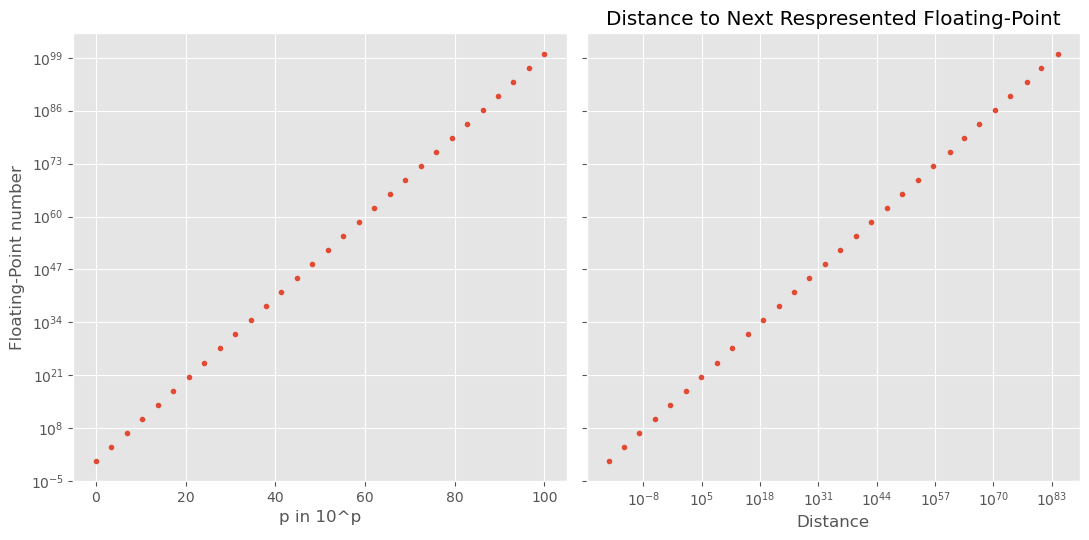

In [19]:
# demonstrated using `np.spacing` "the distance between x and the nearest adjacent number" (and below with `np.nextafter` "the next floating-point value after x1 towards x2, element-wise")
n,p = 30, 100; grid = np.logspace(start=0, stop=p, num=n, base=10.0); fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(11,5.5)); ax[0].plot(np.log10(grid), grid, '.'); ax[0].set_yscale('log'); ax[0].set_ylabel('Floating-Point number'); ax[0].set_xlabel('p in 10^p'); ax[1].plot(np.spacing(grid), grid, '.'); ax[1].set_xlabel('Distance'); ax[1].set_title('Distance to Next Respresented Floating-Point'); ax[1].set_xscale('log'); ax[1].set_yscale('log'); plt.tight_layout() # # np.logspace? # http://jonathansoma.com/lede/data-studio/classes/small-multiples/long-explanation-of-using-plt-subplots-to-create-small-multiples/ #fig.yscale('log')# https://stackoverflow.com/questions/773814/plot-logarithmic-axes-with-matplotlib-in-python # https://matplotlib.org/stable/tutorials/introductory/pyplot.html#logarithmic-and-other-nonlinear-axes # https://numpy.org/doc/stable/reference/generated/numpy.spacing.html#numpy.spacing 

In [ ]:
# https://numpy.org/doc/stable/reference/generated/numpy.nextafter.html#numpy.nextafter
# np.nextafter: "Return the next floating-point value after x1 towards x2, element-wise"
starting_float = 0.
#starting_float = 1e-100
#starting_float = 1e-30
#starting_float = 1.
#starting_float = 10.
#starting_float = 1e+10
#starting_float = 1e+20
#starting_float = 1e+30
#starting_float = 1e+100
#starting_float = 1.7976931348623157e+307
distance_to_next_float = np.nextafter(starting_float, np.Inf) - starting_float
"next float from", starting_float, "is", distance_to_next_float, "away"

<a name="cell-FPN-numovr"></a>

# 4.2.B.a Overflow ([Return to TOC](#cell-TOC))

---

The production of a `Inf` from numeric values is called ***overflow*** 
- ***Overflow*** occurs if the magnitude of a number is greater than the largest representable ***floating point number***
    - either an error or warning is produced or the number is represented as `Inf` (or both) 
    - and the information in the number is lost

In [24]:
2. * 1.7976931348623157e+308, type(2. * 1.7976931348623157e+308)

inf <class 'float'>


In [149]:
# !pip install bitstring

In [152]:
import bitstring
print(bitstring.BitArray(float=1.7976931348623157e+308, length=64).bin)
print(bitstring.BitArray(float=2*1.7976931348623157e+308, length=64).bin)

0111111111101111111111111111111111111111111111111111111111111111
0111111111110000000000000000000000000000000000000000000000000000


In [153]:
# Different "types" of floating-point numbers don't necessarily all treat overflow encounters the same way(!)
# Note that this does not report an error but but the following will
# 10.**309
# And compare this to the following of type `numpy.float64`
# 2. * np.finfo(float).max, type(2. * np.finfo(float).max)

<a name="cell-FPN-numndr"></a>
# 4.2.B.a Underflow ([Return to TOC](#cell-TOC))

---

***Underflow*** is when $x \neq 0$ in ${\rm I\!R}$ but ***floating-point*** representation of the number in $I \!\! F$ is $[x]_c = 0$ 

- ***Underflow*** is a number is closer to `0` than the smallest representable non zero ***floating-point*** number
     - either an error or warning is produced or the number is represented as a `0.0` (or both) 
     - and the information in the number is lost.


***Underflow*** to `0.0` is particularly concerning because unlike an ***overflow*** to `np.Inf` it can easily go unnoticed...
- ***overflow*** `Inf + c = Inf` is arithmetically persistent; but ***underflow*** `0.0` needn't be since `0.0 + c = c`
- and constantly checking for ***underflow*** error or warning messages isn't free

$$\require{cancel}\textstyle y = 2^p\times(1 + \times \sum_{i=1}^{52}b_i 2^{-i}) = 2^{\text{exponent}-\overset{2^{10}-1}{\text{bias}}}\times(1 + \times \sum_{i=1}^{52} b_i2^{-i}) = \overbrace{2^{-\text{bias}}\times(\cancel{1} + \times \sum_{i=1}^{52} b_i2^{-i+1})}^{\text{graceful underflow when exponent}\;=\;0}$$

In [155]:
np.nextafter(0., 1.), 2.**(-1023)*(2.**-51)

(5e-324, 5e-324)

<a name="cell-FPN-graceful"></a>

# 4.2.B.b Density of ${\rm I\!F}$ near `0.0` and Graceful Underflow ([Return to TOC](#cell-TOC))

---

${\rm I\!F}$ is not ***dense*** like ${\rm I\!R}$, it's ***exponentially sparse***

- The larger the ***floating-point*** number, the farther away the nearest representable number is
- Conversely, ***floating-point*** numbers have the ***highest density*** the closet to `0.0` they are
    - And this is further enhance through ***Graceful Underflow***



In [156]:
# Why do "big" numbers only go up to e+308 but "small" numbers have more range down to e-324?
np.finfo(float).max, np.nextafter(0,1)

(1.7976931348623157e+308, 5e-324)

$$\require{cancel}\textstyle y = 2^p\times(1 + \times \sum_{i=1}^{52}b_i 2^{-i}) = 2^{\text{exponent}-\overset{2^{10}-1}{\text{bias}}}\times(1 + \times \sum_{i=1}^{52} b_i2^{-i}) = \overbrace{2^{-\text{bias}}\times(\cancel{1} + \times \sum_{i=1}^{52} b_i2^{-i+1})}^{\text{graceful underflow when exponent}\;=\;0}$$

In [147]:
print("smallest no graceful underflow", 2**(1-1023)); print(bitstring.BitArray(float=2**(1-1023), length=64).bin); print("smallest no graceful underflow", np.nextafter(2**(1-1023),1.), "and nonzero signifcand"); print(bitstring.BitArray(float=np.nextafter(2**(1-1023),1.), length=64).bin); print("largest with graceful underflow", np.nextafter(2**(1-1023),0.)); print(bitstring.BitArray(float=np.nextafter(2**(1-1023),0.), length=64).bin)


smallest no graceful underflow 2.2250738585072014e-308
0000000000010000000000000000000000000000000000000000000000000000
smallest no graceful underflow 2.225073858507202e-308 and nonzero signifcand
0000000000010000000000000000000000000000000000000000000000000001
largest with graceful underflow 2.225073858507201e-308
0000000000001111111111111111111111111111111111111111111111111111


# 4.3 Numerical Errors and Ways to Avoid them

<a name="cell-FPN-roundoff"></a>

# 4.3.A Roundoff Error ([Return to TOC](#cell-TOC))

---

$1.234567891011121 \times 10^{300} + 100000000000$ does not have a ***floating-point*** number representation

closest computer representation $[\cdot]_c$ number available in the ***floating-point*** number system is

$$[1.2345678910111213 \times 10^{300} + 100000000000]_c = 1.234567891011121 \times 10^{300}$$

which has a ***roundoff error*** of $100000000000$

In [158]:
# the closest computer representation of this number has a roundoff error of 100000000000
1.234567891011121e+300 + 100000000000.

1.234567891011121e+300

***Floating-point*** numbers retain the 16 most significant digits<br>followed or preceeded by a sequence of zeros contributed from the $2^{exponent}$ multiplier  

- `1234567891011121` is followed by 285 zeros, and only those first significant digits are retained:<br>adding `100000000000` to that is way down past the 16 most significant digits does not contributed any significant digits and is immediately lost in the ***floating-point*** representation


# 4.3.A Roundoff Error

---


1. "Big" ***floating-point*** numbers dominate and overshadow "small" floating-point numbers<br>making the contributrion of "small" floating-point so insignificant that they get "lost"
2. ***Floating-point*** representations do not have enough precision to track small decimal values in the presense of much larger magnitude numbers
3. Only similiar magnitude ***floating-point*** numbers can be arithmetically combined without inducing **roundoff** error

> The first problem of the week 4 homework in `STA410_W24_Week4_Homework_AdditionVariance.ipynb` will examine ***roundoff error*** in the familar context of *addition*.  You may be surprised to find out that these simple and routine calculation are actually at grave risk for these numerical maladies when ${\rm I\!F}$ is not used carefully for modeling calculations in ${\rm I\!R}$.

<a name="cell-FPN-dense-tricks"></a>

# 4.3.A.a The `log` trick ([Return to TOC](#cell-TOC))

---

- ***Overflow*** and ***underflow*** limits bound computation but not in the same way

- Numeric imprecision increases with the magnitude of $x$ from exponentially sparse ***floating-point representations***

- Numeric resolution is better near `0` (as long as an unnoticed ***underflow*** does not occur)

The obvious way place numeric computations closer to `0`; and, working on a $\log$ scale further benfits precision since

$$\text{multiplication $\longrightarrow$ addition} \quad\quad\text{ and }\quad\quad \text{division $\longrightarrow$ subtraction}$$

Functions extend computational applicability by working on log scales for increased numerical precision near `0` 

- $\quad$ `scipy.special.gammaln` $\quad$ `scipy.special.loggamma`




# 4.3.A.a The `log` trick 

---

- If a computation `<x>` ***underflows*** or ***overflows***<br>the calculation re-expressed in log space as `<logx> =` $\log( <\!x\!> )$ and, subsequently `exp(logx)` may not


- Even if the `<x>` computation doesn't ***underflow*** or ***overflow***, the alternative log space computation may still offer increased precision relative to that naive computation on the original scale 

Any function $f$ on $[0,1]$ may be approximated to arbitrary accuracy with ***Bernstein polynomials***

$$f(x) \approx \sum_{k=0}^m f\left(\frac{k}{m}\right) p_{mk}(x) \quad \text{ with }$$

$$\begin{align*}
p_{mk}(x) = {} & \left(\begin{array}{c}m\\k\end{array}\right) x^k (1-x)^{m-k} \\
 = {} & \exp\left(\log \left(\begin{array}{c}m\\k\end{array}\right) + k \log(x) + (m-k)\log(1-x) \right)
\end{align*}$$

and can avoid ***underflow*** and ***overflow*** for large $m$ on this $\log$ scale

> *This example is taken from Keith Knight's STA410 [notes1.pdf](https://q.utoronto.ca/courses/296804/files?preview=24222782) document*. 

<a name="cell-FPN-dense-taylor"></a>

# 4.3.A.b Taylor Series Expansions ([Return to TOC](#cell-TOC))

--- 

The ***Taylor Series*** of $f(x)$ expanded around $x_0$ is

$$f(x) = \underset{f^{(k)} \text{ is the } k^{th} \text{derivative of } f}{\sum_{k=0}^{\infty} \frac{f^{(k)}(x_0)}{k!}(x-x_0)^k}$$

For example, the ***Taylor Series*** expanded around $0$ of 
$\quad \ln(1+x) = x - \frac{x^2}{2} + \frac{x^3}{3} + \cdots \quad$ and for $e^x$ it's

$$e^x  = e^0 + e^0(x-0) + \frac{e^0}{2}(x-0)^2 + \frac{e^0}{3!}(x-0)^3 + \cdots = 1 + x + \frac{x^2}{2} + \frac{x^3}{3!} + \cdots $$



<!-- > *The examples in this section are is taken from Keith Knight's STA410 [notes1.pdf](https://q.utoronto.ca/courses/296804/files?preview=24222782) document*. -->


In [176]:
def taylors_e(x, approximation_limit=100, verbose=False):
    """Taylor Series Approximation of e^x using approximation_limit (default 100) terms""" 
    series = np.zeros(approximation_limit); xi, ifac, ex =  1., 1., 1. 
    for i in range(approximation_limit):
        xi *= x; ifac *= (i+1); ex += xi/ifac
        if verbose:
          series[i] = ex
    if verbose:
        return series
    return ex # np.exp(-50) is numerically accurate, but only `1/taylors_e(50)` is comparable
np.exp(-50), taylors_e(-50), 1/taylors_e(50) # `taylors_e(-50)` doesn't work

(1.9287498479639178e-22, 280505376192.8196, 1.9287498482666814e-22)

# 4.3.A.b Taylor Series Expansions 

--- 

- `taylors_e(-50)` struggles as alternatingly signed terms "cancel out" and lead to addtions of inherrently mismatched magnitude terms that increasingly entail cumulative contribution losses due to ***roundoff errors*** 

- `1/taylors_e(50)` works because summation accumulates values in increasing magnitude and so retains the contribution of the early summands; then, the reciprocal is near `0` where ***floating-point*** is most precise



(280505376192.8196, 1.9287498482666814e-22)

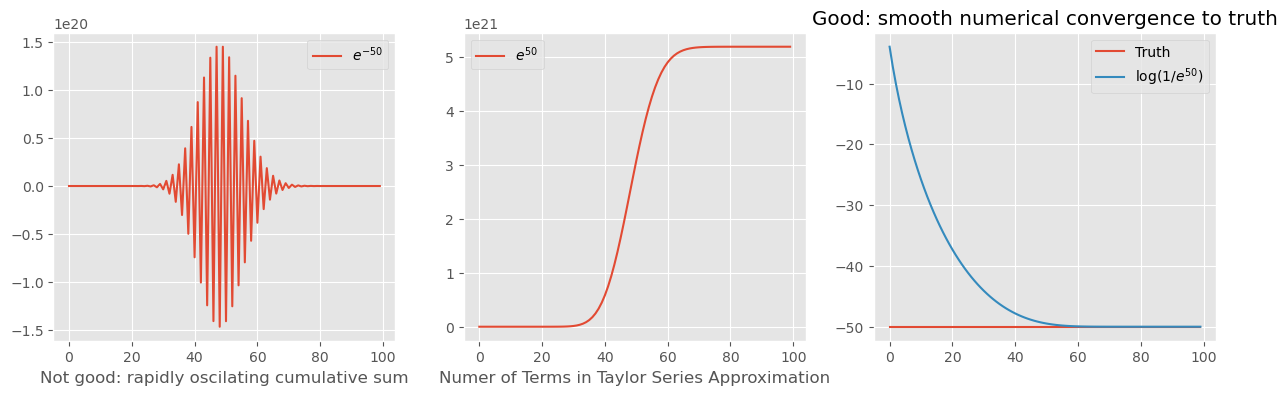

In [177]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4)); x=50; ax[0].plot(taylors_e(-x, approximation_limit=100, verbose=True), label='$e^{-'+str(x)+'}$'); ax[1].plot(taylors_e(x, approximation_limit=100, verbose=True), label='$e^{'+str(x)+'}$'); ax[2].plot([0,99], 2*[-x], label='Truth'); ax[2].plot(np.log(1./taylors_e(x, approximation_limit=100, verbose=True)), label='$\\log(1/e^{'+str(x)+'})$'); ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[0].set_xlabel("Not good: rapidly oscilating cumulative sum"); ax[2].set_title("Good: smooth numerical convergence to truth"); ax[1].set_xlabel("Numer of Terms in Taylor Series Approximation"); 
x = 50; taylors_e(-x, approximation_limit=100, verbose=True)[-1], 1/taylors_e(x, approximation_limit=100, verbose=True)[-1]
# Rapidly oscilating sum ends up broken: earlier summation contributions that would have corrected have been lost to roundoff error

# 4.3.A.b Taylor Series Expansions 

--- 


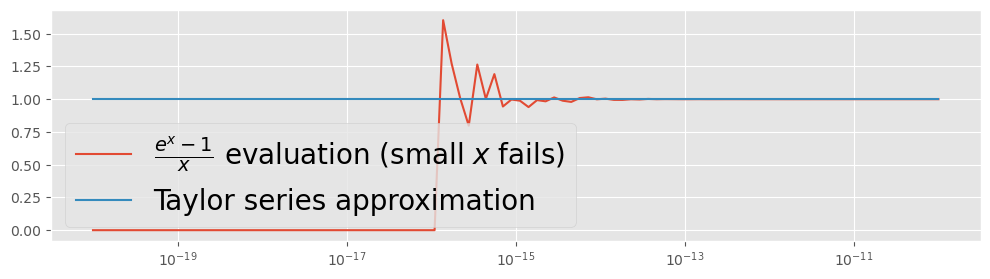

In [181]:
# Taylor series approximation avoids roundoff error and underflow for small magnitude x 
# since higher order terms terms of the approximation don't matter if x is small 
x = np.logspace(-20,-10,100); plt.figure(figsize=(12,3)); plt.plot(x, (np.exp(x)-1)/x, label="$\\frac{e^x-1}{x}$ evaluation (small $x$ fails)")
f = lambda x: 1 + x/2 + x**2/6 + x**3/24; plt.plot(x, f(x), label="Taylor series approximation"); _ = plt.xscale("log"); plt.legend(prop={'size': 20}); 
# The roundoff error affects np.exp(x) for 1e-16 < x < 1e-13
# For x < 1e-16 the problem is underflow where x is numerically 0 so np.exp(x) is 1

In [203]:
# Roundoff error affects np.exp(x) for 1e-16 < x < 1e-13
x = 1e-15; print("x is", x, "or, more exactly"); print(bitstring.BitArray(float=x, length=64).bin); print("np.exp(x) is", np.exp(x), "or, more exactly"); print(bitstring.BitArray(float=np.exp(x), length=64).bin); print('  which doesn\'t have enough bits to be accurately represented ^^^^^^ (but it happens to have "rounded up" here)',"ROUNDOFF ERROR!"); print("So np.exp(x)-1.0 is", np.exp(x)-1.0, "when it should be much close to", x, "so roundoff error is", (np.exp(x)-1.0)-x); print("Not much but the ratio is now quite a bit larger than 1!", (np.exp(x)-1.0)/x)

x is 1e-15 or, more exactly
0011110011010010000000111010111110011110111001110101011000010110
np.exp(x) is 1.000000000000001 or, more exactly
0011111111110000000000000000000000000000000000000000000000000101
  which doesn't have enough bits to be accurately represented ^^^^^^ (but it happens to have "rounded up" here) ROUNDOFF ERROR!
So np.exp(x)-1.0 is 1.1102230246251565e-15 when it should be much close to 1e-15 so roundoff error is 1.1022302462515646e-16
Not much but the ratio is now quite a bit larger than 1! 1.1102230246251565


In [201]:
1e-16, np.exp(1e-16) # For x < 1e-16 the problem is the underflow where x is numerically 0 so np.exp(x) is 1

(1e-16, 1.0)

<a name="cell-FPN-catacan"></a>

# 4.3.B Catastrophic Cancellation ([Return to TOC](#cell-TOC))
---

Any time a ***floating-point*** representation $[\cdot]_c$ is wrong information is lost

In [204]:
1e+300 - (1e+300 + 100000000000.) # That's extra weird/bad because `100000000000.` can of course be represented as a floating number

0.0

In [205]:
100000000000. # plus it's a really big number... seems strange we can't keep track of it...

100000000000.0

But ***catastrophic cancellation*** is distinct from ***underflow*** 

- In ***underflow*** a number that is closer to $0$ than the smallest representable number is assigned a value of `0.0`
- In ***catastrophic cancellation*** the information is lost prior to arriving at `0.0`


The extra value `100000000000` above is lost before the subtraction is even attempted because it cannot be kept track of relative to the significant digits in `1e+300`... It *WOULD have worked* if it had been done it like this:

In [206]:
1e+300 - 1e+300 + 100000000000

100000000000.0

# 4.3.B Catastrophic Cancellation 

---

***Catastrophic cancellation*** is a risk wheh two oppositely signed numbers with large magnitudes are reprsented with same absolute magnitude as a result of ***roundoff error*** so

$$|x_1| \not = |x_2| \quad \text{ but } \quad [|x_1|]_c = [|x_2|]_c \quad \text{ so } \quad [x_1]_c + [x_2]_c = 0 \quad \text{ even if } \quad  x_1+x_2 = [x_1+x_2]_c $$

the true difference theoretically could have been sufficiently represented as a ***floating-point*** number exactly

The ***machine-epsilon*** perspective characterizes ***catastrphic cancelation*** as

$$0 = [x_1]_c - [x_2]_c = x_1(1+\epsilon_1) - x_2(1+\epsilon_2) =  \underbrace{x_1 - x_2}_{\not = 0} + \underbrace{x_1\epsilon_1- x_2\epsilon_2}_{= -(x_1-x_2)}$$

which only occurs if the true difference $x_1 - x_2$ and the numerical error $x_1\epsilon_1- x_2\epsilon_2$ have identical magnitudes so

$$|x_1| \text{ and } |x_2| \quad \text{ must be large while } \quad 
|x_1 - x_2| \quad \text{ must be small so that } \quad |x_1\epsilon_1- x_2\epsilon_2| = |x_1 - x_2|$$

since $\epsilon_1$ and $\epsilon_2$ have small magnitudes

<!-- > *This presentation is adopted from Keith Knight's STA410 [notes1.pdf](https://q.utoronto.ca/courses/296804/files?preview=24222782) document*.  -->



# 4.3.B Catastrophic Cancellation 

---

The second problem of the week 4 homework in `STA410_W24_Week4_Homework_AdditionVariance.ipynb` will examine ***catastrophic cancellation*** in the familar context of *sample sum of squares* calculations.  You may be surprised to find out that these simple and routine calculation are actually at risk for this numerical malady when ${\rm I\!F}$ is not used carefully for modeling calculations in ${\rm I\!R}$.

In [218]:
# E.g. here are two sample variance calculations that suffer
# Catastrophic Cancellation due to massive roundoff error
n = 100
from scipy import stats
x = stats.norm(loc=1e10, scale=1.).rvs(size=n)
print(x.var())
# sum_i (x_i-xbar)**2/n-1
# sum_i x_i**2 + n xbar**2 - 2 xbar sum_i x_i
# sum_i x_i**2 + n xbar**2 - 2 xbar n xbar
print( ((x**2).sum() - x.sum()**2/n)/(n-1) )
print( ((x**2).mean() - x.mean()**2)*n/(n-1) )

1.0894360064957436
21183.353535353537
0.0


<a name="cell-FPN-quadratic-formula"></a>

# 4.3.C The Quadratic Formula ([Return to TOC](#cell-TOC))

---

Roots of $ax^2+bx+c$ are found with the celebrated ***quadratic formula*** which has real solutions when $b^2 - 4ac \geq 0$

$$\frac{-b \pm \sqrt{b^2 - 4ac}}{2a}$$ 

However... ***roundoff error*** in $b^2-4ac$ can cause $\left[\sqrt{b^2-4ac}\right]_c = b$ resulting in ***catastrophic cancellation*** in the numerator for "$+$" solution; but, would only cause ***roundoff error*** but not ***catastrophic cancellation*** in the "$-$" solution

$$x_1 = \frac{-b + \left[\sqrt{b^2 - 4ac}\right]_c}{2a} = 0 
\quad\quad\quad x_2 = \frac{-b - \left[\sqrt{b^2 - 4ac}\right]_c}{2a} = -\frac{b}{a}$$

Using this $x_2$ solution, we can solve for $x_1$ in the product of $x_2x_1$ which can be computed by multiplying the two quadratic formula forms together and then substituting in the first $x_2$ solution (with ***roundoff error***), which yields

$$ x_1x_2 = \frac{b^2 - \left(\sqrt{b^2 - 4ac}\right)^2}{(2a)^2} = \frac{c}{a} \quad \Longrightarrow \quad x_1 = -\frac{a}{b}\frac{c}{a} = -\frac{c}{b}$$

# 4.3.C The Quadratic Formula 

---

In [211]:
a, b, c = -2, 1e+10, 100; f = lambda x: a*x**2 + b*x + c; import inspect
print(str(inspect.getsource(f)).replace('a*',str(a)).replace('b*',str(b)).replace('c',str(c)).replace(' = lambda x:', '(x) = '))
x1 = -b + np.sqrt(b**2 - 4*a*c); print('x1 =', x1, ': f(x1) =', f(x1)); print("This is not a root of f due to Catastrophic Cancellation\n")
x2 = -b/a; print('x2 =', x2, ': f(x2) =', f(x2)); print("This is as close as possible to a root of f due to Roundoff Error\n")
x1b = -c/b; print("x1' =", x1b, ": f(x1') =", f(x1b)); print("We can find a root of f by using a different numerical calculation!")

a, b, 100 = -2, 1e+10, 100; f(x) =  -2x**2 + 10000000000.0x + 100; import inspe100t

x1 = 0.0 : f(x1) = 100.0
This is not a root of f due to Catastrophic Cancellation

x2 = 5000000000.0 : f(x2) = 100.0
This is as close as possible to a root of f due to Roundoff Error

x1' = -1e-08 : f(x1') = 0.0
We can find a root of f by using a different numerical calculation!


This example nicely demonstrates the meaning, relevance, and applicability of James E. Gentle's repeated mantra:

- *Computer numbers are not the same as real numbers, and the arithmatic operations on computer numbers are not exactly the same as those of ordinary arithmetic. The form of a mathematical expression and the way the expression should be evaluated in practice may be quite different.*

In any calculation we attempt we must make the problem amenable to the tools we have available.  We must identify numerical calculations that will both supply the answers we require as well as conform to the limitations and capabilities of our computational system ${\rm I\!F}$. ${\rm I\!F}$ is only a good model approximating ${\rm I\!R}$ when it's used appropriately.  

  *This example is inspired by the **Catastrophic Cancellation** section in Chapter 2.3 **Computer Storage and Arithmatic: Errors** following Chapter 2.2 **The Floating-Point Number System** on pages 100-101 of James E. Gentle's **Computational Statistics** textbook.*

# 4.4 Numerical Precision in Linear Algebra

<a name="cell-sovling-condition"></a>

# 4.4.A Condition ([Return to TOC](#cell-TOC))

---


The ***condition*** of a mathematical function $f$ addresses whether 

$$\underset{\large \text{$f$ is well-conditioned}}{x+\epsilon_x \approx x \Longrightarrow f(x+\epsilon_x) \approx f(x)} \quad \text{ or } \quad \underset{\large \text{$f$ is ill-conditioned}}{x+\epsilon_x \approx x \cancel{\Longrightarrow} f(x+\epsilon_x) \approx f(x)}$$

***Condition*** is a mathematical property of a problem, but small changes $\epsilon_x$ in the input of a problem $x$ can be caused by ***roundoff error***, so the ***condition of a problem*** is a key issue for ***numerical accuracy***.

In [4]:
import numpy as np; from scipy import stats
np.random.seed(2); n,q=3,10; Atilde = stats.norm.rvs(size=(q,n))*0.01+np.arange(q).reshape(q,1)
A = Atilde.T@Atilde; U,d,Vt = np.linalg.svd(A); print("Singular Values of A", d, "\n")

# Now we'll see what Ax is like versus A(x+epsion) for some small epsilon
x1 = Vt[[2],:].T; epsilon = Vt[[0],:].T/1000; x2 = x1+epsilon; diff = (x1-x2)
print("Difference between x and x+epsion", (diff.T@diff)**0.5)
diff = (A@x1-A@x2) 
print("Difference between A(x) and A(x+epsion)", (diff.T@diff)**0.5)
# very different for such a small difference in the input...

Singular Values of A [8.54028441e+02 1.33091582e-03 7.28268899e-04] 

Difference between x and x+epsion [[0.001]]
Difference between A(x) and A(x+epsion) [[0.85402844]]


<a name="cell-sovling-stability"></a>

# 4.4.A.a Stability and Error Analysis ([Return to TOC](#cell-TOC))

---

There are several additional terms that are related to the ***condition*** of a problem

***Robust*** algorithms (programs) either 
- warn of the presence of ***ill-conditioning*** and may or may not attempt to compute an answer
- or (for ***well-conditioned problems***) give answers as numerically correct as possible under the available ***precision***

Computation $\tilde f(\cdot)$ calculating $f(\cdot)$ is (backward) ***stable*** if answers are true solutions to <u>existing</u> "nearby problems":

$$\tilde f(x) \neq f(x) \quad \text{ but } \quad f(\tilde x = x+\epsilon_x) = \tilde f(x)$$

***Stability*** does not overcome ***ill-conditioned problems*** since $f(\tilde x = x+\epsilon_x) = \tilde f(x) \cancel{\Longrightarrow} f(\tilde x = x+\epsilon_x) \approx f(x)$

**Stability** only means computations are "close" as a matter of the  numerical ***precision*** of the input; but **stability** says nothing about the ***condition*** of a problem, which is how quickly $f(\tilde x = x+\epsilon_x)$ changes from $f(x)$ for small perturbations $\epsilon_x$. Precison of computation $\tilde f(x) = f(\tilde x= x+\epsilon_x)$ does not mean these values are close to $f(x)$. 
   

# 4.4.A.a Stability and Error Analysis 


***Forward error analysis*** compares the difference between computed and true answers to problems; but, computation is done in ${\rm I\!F}$ and the correct answers in ${\rm I\!R}$ may be neither known nor representable in ${\rm I\!F}$ so this is not generally useful

***Backward error analysis*** is instead based fully on computations within ${\rm I\!F}$ and evaluates how large $\epsilon_x$ the difference between $x$ and $\tilde x$ is
for $\tilde f(\tilde x)$ is computed correctly equaling $f(\tilde x)$ while having the same value as computation $\tilde f(x)$ 

| | | |
|-|-|-|
| $x, \tilde x=x+\epsilon_x \in {\rm I\!F}$ | $\quad \quad  \tilde f(x)$ the computed version of the true answer $f(x)\quad \quad $ |  $\tilde f(x) = f(\tilde x) = \tilde f(\tilde x)$ |
    

- $\tilde f(\tilde x) = f(\tilde x)$ is easily confirmed by checking if ***roundoff*** error was encountered during the calculation) thus, if $x$ is found such that $\tilde f(x) = \tilde f(\tilde x) = f(\tilde x)$, then the difference between $x$ and $\tilde x$ can of course be evaluated

|![Nick Higham's Blog](https://nickhigham.files.wordpress.com/2020/03/berr-fig-2.jpg?w=500&zoom=2)|***Backward error analysis*** can be seen to be defined in the same terms as (backward) ***stability*** since<br><br>if $\epsilon_x$ is small where $\tilde f(x) = f(\tilde x = x + \epsilon_x)$<br><br>i.e., $\tilde f(x)$ is the answer to the $\epsilon_x$-close "nearby problem"<br><br>then the algorithm is (backward) ***stable*** (at $x$) since answers here are true solutions to an existing "nearby problem".|
|-|-|  
|Taken from Nick Higham's website |https://nhigham.com/2020/03/25/what-is-backward-error/| |





<!--
    $$b+\epsilon_b \approx b \cancel{\Longrightarrow} f_A(b+\epsilon_b) \approx f_A(b)$$
    > E.g., $x = f_A(b) = A^{-1}b$; but, if $\kappa(A)$ is large, then $\frac{||\epsilon_x||}{||x||}$ may be large even if $\frac{||\epsilon_b||}{||b||}$ is small, since $\frac{||\epsilon_x||}{||x||} \leq \kappa(A) \frac{||\epsilon_b||}{||b||}$ so 
  >
  > $$b+\epsilon_b \approx b \cancel{\Longrightarrow} f_A(b+\epsilon_b) \approx f_A(b) $$
-->

<!--
  > and no "nearby problem" may exist so
  >
  > $$\underset{\text{for all choices of small $\epsilon_b$ and $\epsilon_x$} }{f_A(b+\epsilon_b) \not = \tilde f_A(b) + \epsilon_x}$$

  > $$\require{cancel} \underset{ \text{where $f(\tilde b)\\, \approx f(b)$ if $f$ is ill-conditioned} }{\overset{\text{there are no nearby problems } \tilde b \\, = \\, b+\epsilon_b}{\cancel{f(\tilde b = b+\epsilon_b) = f(b) + \epsilon}}}$$

-->

<!-- $\require{enclose} \enclose{horizontalstrike}{}$ -->


<a name="cell-sovling-condition-stiffness"></a>

# 4.4.A.b Pragmatic "Condition" Numbers: Stiffness ([Return to TOC](#cell-TOC))

---

Technically, the ***condition of a problem*** characterizes how dramatically a function output changes for "nearby inputs"; however, since a primary driver of small variation in input is numerical imprecision from ***roundoff error***, some ***condition numbers*** simply characterize when a computation becomes "numerically unstable" solely as a result of numerical issues. The ***stiffness*** of a sample variance calculation is an example of this kind of ***condition number***

$$\begin{align*}\kappa(x) = {} & \frac{\sum_{i=1}^n x_i^2}{s\sqrt{n-1}} = \frac{\sum_{i=1}^n x_i^2}{\sum_{i=1}^n x_i^2 - n\left(\frac{\sum_{i=1}^n x_i}{n}\right)^2}\\
\text{where } s^2 = {} & \frac{\sum_{i=1}^n (x_i-\bar x)^2}{n-1}\\
\end{align*}$$

The ***stiffness condition number*** $\kappa(x) \approx 1$ when $\bar x \approx 0$ but $\kappa(x) >> 1$ when $\bar x >> s$, which is exactly when a sample variance calculation can fail numerically (and is an example why "center and scale your data" mantra is good practice).

- Sample variance calculations were previously illustrated to fail as a result of ***Catastrophic Cancellation*** (exactly when $\bar x >> s$), and an alternative sample variance calculations were considered with respect to this issue.

Pragmatically, both ***stiffness*** and ***condition number*** $\kappa(A)$ address equivalent objectives of identifying if the computations of a function are expected to be "numerically volatile". 

<a name="cell-sovling-Axb-math-svd"></a>

# 4.4.B Singular Value Decomposition (SVD) ([Return to TOC](#cell-TOC))

---

For any matrix $A_{n\times m}$ there exists a ***(compact) singular value decomposition (SVD)***

\begin{align*}
A_{n\times m} = {} & U_{n\times r} D_{r\times r} (V^T)_{r\times m} \quad \text{ such that} \\
\end{align*}

$U_{n\times r}$ and $V_{m\times r}$ are ***semi-orthonormal matrices***

$$\begin{align*}
U_{\cdot j}^TU_{\cdot j} & {} = \,\;1\;\,  = V_{\cdot j}^TV_{\cdot j} & {} \textbf{normal vectors}\\
U_{\cdot j}^TU_{\cdot k} & {} = \,\;0\;\,  = V_{\cdot j}^TV_{\cdot k}, j\not=k & {} \textbf{orthogonality}\\
U^TU & {} = I_{r\times r}  = V^TV& {} \textbf{semi-orthonormality} &\;\quad \text{ so } \quad UU^T \neq I_{r \times r} \left\{\begin{array}{ll} = VV^T & \text{if }r=m\\ \neq VV^T & \text{if }r\neq m\\  \end{array}\right.
\end{align*}$$

$D_{r\times r}$ is a ***nonnegative diagonal matrix*** with $D_{ij}=0$ for $i \not = j$ and with ***singular values*** $\lambda_i$ ordered on the diagonal 

$$D_{11}=\lambda_1 \geq D_{22}=\lambda_2 \geq \cdots \geq D_{rr}=\lambda_r > 0  \text{ where } r = \text{rank}(A_{n\times m}) \leq \min(n,m)   \text{ and }  \lambda_j = 0 \text{ for } j>r$$

which is what gives rise to the ***compact*** version of the ***SVD***.




<a name="cell-sovling-Axb-math-svd-vs-eigendecomposition"></a>

# 4.4.B.a SVD Determinants ([Return to TOC](#cell-TOC))

---

For ***square*** matrices $A_{n\times m} = A_{n\times n}$ (i.e., $m=n$) we have that the product of the ***singular values*** of $A_{n\times n}$ (not to be confused with the similar formula for ***eigenvalues***) is the ***absolute value of the determinant***

$$|\det(A_{n\times n})| = \prod_{i=1}^n \lambda_i$$

so if $r<n$, then from the ***compact SVD***, $\lambda_j = 0$ for $j = (r+1), ..., n$, then $|\det(A_{n\times n})| = 0$.

# 4.4.B.b SVD versus Eigendecomposition
---

For ***non-square full-rank*** $\tilde A = U\tilde DV^T$ the ***square*** matrix

$$A = \tilde A^T \tilde A = VDU^TUDV^T = V\tilde D \tilde DV^T = V DV^T$$

is ***symmetric*** and ***positive definite*** (and thus satisfies the requirements of ***covariance matrices***).  The $V DV^T$ factorization is the ***SVD*** where $U=V$ and it is also the ***eigendecomposition***. Thus, these two factorization are equivalent in the case of ***covariance matrices*** (and the ***singular values*** are equal to the ***eigenvalues***) but this is [not true in general](https://math.stackexchange.com/questions/127500/what-is-the-difference-between-singular-value-and-eigenvalue) as ***eigenvalues*** of a ***full-rank square*** matrix may be negative, but ***singular values*** are always non-negative.


# 4.4.B.b SVD versus Eigendecomposition 

---

In [15]:
Atilde = stats.norm.rvs(size=(10,3)); A = Atilde.T@Atilde; U,d,Vt = np.linalg.svd(A); print("SVD"); print("U=\n",U,"\nD=\n",np.diag(d),"\nVt=\n",Vt)
eval,evec=np.linalg.eig(A) # np.linalg.eig doesn't sort eigenvalues; signs on the columns of the eigenvectors can be negated
print("Eigendecomposition"); print("Vt=\n",evec.T,"\nD=\n",np.diag(eval))# otherwise the factorizations are mathematically equivalent

SVD
U=
 [[ 0.12406089  0.5679718  -0.81364423]
 [ 0.43176626 -0.76918248 -0.47110105]
 [-0.893413   -0.29285891 -0.34065652]] 
D=
 [[17.67157136  0.          0.        ]
 [ 0.         12.56780012  0.        ]
 [ 0.          0.          1.7920602 ]] 
Vt=
 [[ 0.12406089  0.43176626 -0.893413  ]
 [ 0.5679718  -0.76918248 -0.29285891]
 [-0.81364423 -0.47110105 -0.34065652]]
Eigendecomposition
Vt=
 [[-0.81364423 -0.47110105 -0.34065652]
 [-0.5679718   0.76918248  0.29285891]
 [-0.12406089 -0.43176626  0.893413  ]] 
D=
 [[ 1.7920602   0.          0.        ]
 [ 0.         12.56780012  0.        ]
 [ 0.          0.         17.67157136]]


In [16]:
# the factorizations are no longer mathematically equivalent
A = stats.norm.rvs(size=(3,3)); U,d,Vt = np.linalg.svd(A); print("SVD"); print("U=\n",U,"\nD=\n",np.diag(d),"\nVt=\n",Vt)
eval,evec=np.linalg.eig(A); print("Eigendecomposition"); print("Vt=\n",evec.T,"\nD=\n",np.diag(eval))
# SVD produces real-valued factorizations while eigendecompositions are often imaginary

SVD
U=
 [[-0.0613847   0.39370185 -0.91718634]
 [-0.78984699 -0.58096693 -0.19651758]
 [-0.61022427  0.71237369  0.3466267 ]] 
D=
 [[2.52955103 0.         0.        ]
 [0.         0.90674834 0.        ]
 [0.         0.         0.22701031]] 
Vt=
 [[ 0.0718629   0.98754545 -0.13996325]
 [-0.92334455  0.11893443  0.36508826]
 [ 0.3771877   0.102998    0.92039168]]
Eigendecomposition
Vt=
 [[-0.04312759  0.01248078  0.99899161]
 [-0.6942457  -0.16698789 -0.70009853]
 [ 0.08541445  0.85364389  0.51380589]] 
D=
 [[ 0.53556899  0.          0.        ]
 [ 0.         -0.49104957  0.        ]
 [ 0.          0.         -1.97986252]]


<a name="cell-sovling-Axb-UDVt"></a>

# 4.4.B.c Understanding $Ax$ with $Ax=UDV^T\!x$ ([Return to TOC](#cell-TOC))

---

$$Ax = (UDV^T)x = \sum_{k=1}^n \lambda_k \left[V^Tx\right]_k U_{\cdot k}$$

shows that $Ax$ is actually the weighted sum of the ***orthonormal*** column vectors $U_{\cdot k}$ where the relative contribuition of each depends on the corresponding ***singular value*** $\lambda_k$ and the $k^{th}$ element of $V^Tx$. 


When the ***singular values*** $\lambda_i$ have comparable magnitudes the contributions are on similar scales; but, if the ***singular values*** $\lambda_i$ have different magnitudes the contributions can be on highly different scales. From the perspective of ***numerical accuracy***, adding ***floating-point*** numbers on different scales will result in ***roundoff error***. 

In [14]:
np.random.seed(2); n,q=3,10; Atilde = stats.norm.rvs(size=(q,n))*0.01+np.arange(q).reshape(q,1)
A = Atilde.T@Atilde; U,d,Vt = np.linalg.svd(A); print("Singular Values", d)
x = np.ones((n,1)); print("Ax=", A@x); print("which as a singular values weighted sum is"); weighted_sum = 0*x
for i in range(n):
  weighted_sum += d[i]*(Vt@x)[i]*U[:,[i]]
print(weighted_sum)

Singular Values [8.54028441e+02 1.33091582e-03 7.28268899e-04]
Ax= [[853.85756955]
 [853.91389283]
 [854.31371532]]
which as a singular values weighted sum is
[[853.85756955]
 [853.91389283]
 [854.31371532]]


<a name="cell-sovling-condition-matrix"></a>

## 4.4.C Matrix Condition Number ([Return to TOC](#cell-TOC))

---

For $f_A(x)=Ax=b$ the ***condition*** of $f_A$ depends on the relative magnitudes of the ***singular values*** of the $A$ matrix 

$$Ax = (UDV^T)x = \sum_{k=1}^n \lambda_k \left[V^Tx\right]_k U_{\cdot k}$$

because $\left[V^Tx\right]_k$ is the dot product of the $k^{th}$ column of $V$ with $x$ which will be $0$ if these vectors are ***orthogonal***; but, if they are not ***orthogonal*** then this dot product is scaled by $\lambda_k$ which could be very large. If all $\lambda_{k'\neq k}$ are very small, the $\lambda_k \left[V^Tx\right]_k$ multiplier could thus shift from $0$ to a large nonzero on the basis of some small $\epsilon>0$ as seen above

$$\underset{\text{if the singular values of $A$ have similar small magnitudes}}{\overset{\Large \text{$f_A(x) = Ax$ is well-conditioned}}{x+\epsilon_x \approx x \Longrightarrow \underset{f_A(x+\epsilon_x) \approx f_A(x)}{A(x+\epsilon_x) \approx Ax}}} \quad \text{ or } \quad \underset{\text{if the singular values of $A$ don't have similar magnitudes}}{\overset{\Large \text{$f_A(x)=Ax$ is ill-conditioned}}{x+\epsilon_x \approx x \cancel{\Longrightarrow} \underset{f_A(x+\epsilon_x) \approx f_A(x)}{A(x+\epsilon_x) \approx Ax}}}$$


Since the relative spacing of ***singular values*** is bounded by the smallest and largest ***singular values***, an easy useful general ***matrix condition number*** is just $\kappa(A) = \frac{\lambda_{max}}{\lambda_{min}}$ the ratio of the largest and smallest ***singular values***. If this  ***matrix condition number*** is small then the matrix is said to be ***well-conditioned*** otherwise it's said to be ***ill-conditioned***.

## 4.4.C Matrix Condition Number

---



In [2]:
# Condition Numbers are a good check for linear models
import statsmodels.api as sm; mtcars = sm.datasets.get_rdataset("mtcars")
Y = mtcars.data[['mpg']].values; X = mtcars.data[['cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear','carb']].values
X = sm.add_constant(X); model = sm.OLS(Y,X); results = model.fit(); results.summary2().tables[-1]

,0,1,2,3
0,Omnibus:,1.907,Durbin-Watson:,1.861
1,Prob(Omnibus):,0.385,Jarque-Bera (JB):,1.747
2,Skew:,0.521,Prob(JB):,0.418
3,Kurtosis:,2.526,Condition No.:,12213


In [4]:
# Confirmed
import numpy as np; D = np.linalg.svd(X)[1]; D[0]/D[-1]

12212.766034567683

In [5]:
# Confirmed
np.linalg.cond(X)

12212.766034567692

In [6]:
# breaking the condition number
np.linalg.svd(np.ones((2,2)))[1], np.linalg.cond(np.ones((2,2)))

(array([2.00000000e+00, 3.35470445e-17]), 5.961777047638983e+16)